# Automatic Differentiation in RadiativeTransfer.jl

This tutorial will demonstrate the automatic differentiation (autodiff) features in the RadiativeTransfer.jl package. Autodiff features are enabled in both the CrossSection and PhaseFunction modules' calculations. 

If you would like to directly see how to perform AD in RadiativeTransfer.jl functions, skip ahead to the [examples section](#Examples). But first, let's see how autodifferentiation actually _works_. 

## What is Automatic Differentiation?

Automatic Differentiation is a set of techniques used to compute the derivative of numeric functions written as computer code. Autodiff is distinct from other well-known derivative-finding techniques such as: 

- Symbolic differentiation, in which an input formula is algebraically manipulated using differentiation rules to generate the derivative formula. 
- Numerical differentiation (method of finite differences), in which the derivative is estimated by taking the slope between the target point $(x, f(x))$ and a nearby point, $(x+\epsilon, f(x + \epsilon))$

Automatic differentiation uses dual numbers to calculate function outputs and their derivatives. The following demonstration is borrowed from a Julia AD tutorial found [here](https://github.com/JuliaAcademy/JuliaTutorials/blob/master/introductory-tutorials/intro-to-julia/AutoDiff.ipynb). 

To motivate the problem, let's start with an example function: the Babylonian sqrt function, which simply computes sqrt(x). The algorithm is simple: 

> Repeat $t\leftarrow(t+x/t)/ 2$ until $t$ converges to $\sqrt{x}$.

Each iteration has one addition and two division operations. In julia, the function looks like:



In [2]:
function Babylonian(x; N = 10)
    t = (1 + x)/2
    for i = 2:N; t = (t + x/t)/2 end
    t
end

Babylonian (generic function with 1 method)

We check that the function works: 

In [3]:
Babylonian(π), √π

(1.7724538509055159, 1.7724538509055159)

In [4]:
x = 2; Babylonian(x), √x

(1.414213562373095, 1.4142135623730951)

Cool, now let's implement the autodiff feature for this function by introducing "dual" numbers that we pass in to `Babylonian` as `x`, instead of passing a simple number. A dual number in our implementation is a tuple that consists of two numbers: the function value at a point and it's derivative there. 

In [5]:
struct Dual <: Number
    f::Tuple{Float64, Float64}
end

We know some basic rules for derivatives, so we can implement those rules for our dual numbers. 

Namely, we know the: 
- Sum rule: $(x + y)' = x' + y'$
- Quotient rule: $(x/y)' = (yx' - xy')/y^2$

In [6]:
import Base: +, /, convert, promote_rule

# Implement addition and division of dual numbers
+(x::Dual, y::Dual) = Dual(x.f .+ y.f)
/(x::Dual, y::Dual) = Dual((x.f[1]/y.f[1], (y.f[1]*x.f[2] - x.f[1]*y.f[2])/y.f[1]^2))

# How to convert a real number x to a dual (value=x, deriv=0)
convert(::Type{Dual}, x::Real) = Dual((x,zero(x)))

# When given a tuple and number, prefer conversion to Dual
# This is needed when we do 1 + x where x <: Dual
promote_rule(::Type{Dual}, ::Type{<:Number}) = Dual

promote_rule (generic function with 123 methods)

Now with no extra effort, we can pass a dual input to Babylonian!

In [7]:
x=2; Babylonian(Dual((x,1))),(√x,.5/√x)

(Dual((1.414213562373095, 0.35355339059327373)), (1.4142135623730951, 0.35355339059327373))

This is the underlying process of automatic differentiation using dual numbers. The function derivative is *not* approximated numerically and is *not* evaluated symbolically. Rather, in autodiff, each arithmetic operation in the original function is accompanied by the derivative operation and so, a single forward pass through the function directly yields its computed derivative. 

## Where do we use AD in Radiative Transfer calculations? 

1. In computing the partial derivatives of cross-section calculations with respect to pressure and temperature. 
2. In computing the partial derivatives of phase-function calculations with respect to aerosol μ, σ and refractive index nᵣ, nᵢ

### Cross-Section Example

In [8]:
using RadiativeTransfer
using RadiativeTransfer.CrossSection
using RadiativeTransfer.PhaseFunction
using Plots

┌ Info: CUDA-enabled GPU(s) detected:
└ @ RadiativeTransfer /home/rjeyaram/RadiativeTransfer/src/RadiativeTransfer.jl:34
┌ Info: CUDA.CuDevice(0): Tesla K80
└ @ RadiativeTransfer /home/rjeyaram/RadiativeTransfer/src/RadiativeTransfer.jl:36
┌ Info: CUDA.CuDevice(1): Tesla K80
└ @ RadiativeTransfer /home/rjeyaram/RadiativeTransfer/src/RadiativeTransfer.jl:36
┌ Info: CUDA.CuDevice(2): Tesla K80
└ @ RadiativeTransfer /home/rjeyaram/RadiativeTransfer/src/RadiativeTransfer.jl:36
┌ Info: CUDA.CuDevice(3): Tesla K80
└ @ RadiativeTransfer /home/rjeyaram/RadiativeTransfer/src/RadiativeTransfer.jl:36


In [9]:
# To calculate cross-section with autodifferentiation w.r.t. p, T:
hitran_data = read_hitran(artifact("hitran_molec_id_2_CO2"), mol=2, iso=1, ν_min=6000, ν_max=6400)
model = make_hitran_model(hitran_data, Voigt())
cross_section, derivs = absorption_cross_section(model, 6000:0.01:6400, 1000.1, 296.1, autodiff=true);

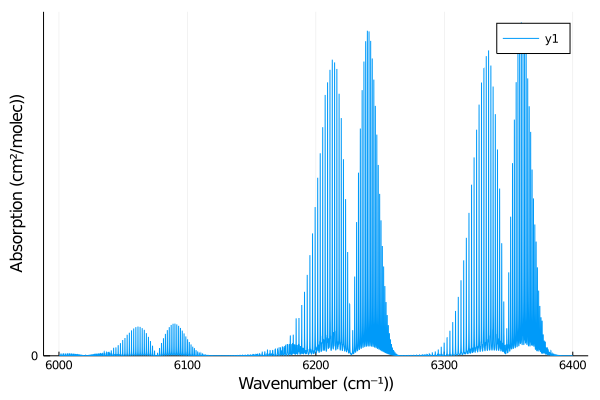

In [10]:
gr()
plot(6000:0.01:6400, cross_section, ylims=(0, 8e-23))
xlabel!("Wavenumber (cm⁻¹))")
ylabel!("Absorption (cm²/molec))")

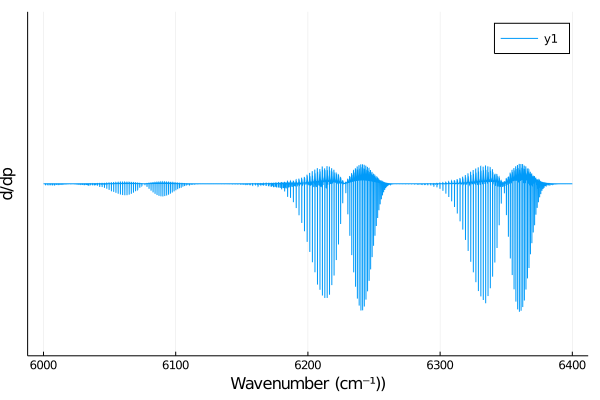

In [14]:
plot(6000:0.01:6400, derivs[:,1], ylims=(-1e-25, 1e-25))
xlabel!("Wavenumber (cm⁻¹))")
ylabel!("d/dp")

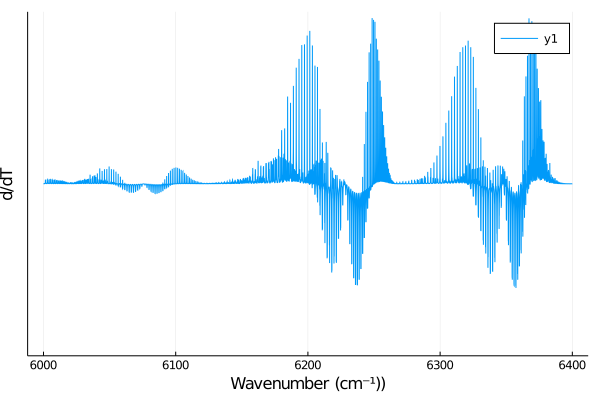

In [15]:
plot(6000:0.01:6400, derivs[:,2], ylims=(-2e-25, 2e-25))
xlabel!("Wavenumber (cm⁻¹))")
ylabel!("d/dT")

### Phase-Function Example